In [72]:
## EPILEPSY DATA
import h5py
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import zlib
import sys
import zstd
import math
from tqdm import tqdm
import random
from scipy import stats

# note that zstd should be installed with 'pip3 install zstd'

In [2]:
cd /scratch/

/scratch


In [29]:
## ACCESS DATA
filename = r'PS041_1000hz.h5'
f = h5py.File(filename, 'r')

# read the keys of the file: these are subsets of the data stored in the file
print(list(f.keys()))

# we are interested in neural data.
data = f['neural']
print(data.shape)

# from the .shape call, we can see that the 1000 Hz data has 50 channels.

# downsample to 1 Hz:
#data_downsamp = data[:,0:-1:1000]

['dc', 'misc', 'neural']
(50, 180580000)


In [32]:
# get recording units
print(f['neural'].attrs['units'])

uV


In [16]:
## TRUE SEIZURE TIMES, RECORDING GAPS
# we can additionally clean the recording using metadata.
filename = r'PS041.h5'
f = h5py.File(filename, 'r')

# note that I will convert 10 kHz times to 1 Hz times
seize_times = f.attrs['seizures_start']/10000
gaps = f.attrs['record_gaps']/10000

# delete gaps in recording using metadata
data1Hz = data_downsamp
for i in range(len(gaps)):
    start = math.floor(gaps[i][0])
    stop = math.ceil(gaps[i][1])
    data1Hz = np.delete(data1Hz,slice(start,stop),axis=1)

print(data_downsamp.shape)
print(data1Hz.shape)

(50, 180580)
(50, 180001)


In [22]:
## LOSSLESS COMPRESSION RATIOS
gzip_icr = [] 
zstd_icr = []
i = 0

for i in tqdm(range(data1Hz.shape[1])):
    if i < 10:
        temp = data1Hz[:,0:i+10]
        temp = temp.copy(order='C')
    if i > data1Hz.shape[1]-10:
        temp = data1Hz[:,i-10:]
        temp = temp.copy(order='C')
    else:
        temp = data1Hz[:,i-10:i+10]
        temp = temp.copy(order='C')
        
    # using gzip
    x = zlib.compress(temp)
    curr_gzip_icr = sys.getsizeof(temp)/sys.getsizeof(x)
    #curr_gzip_icr = len(temp)/len(x)
    gzip_icr.append(curr_gzip_icr)
    
    # using zstd
    y = zstd.compress(temp)
    curr_zstd_icr = sys.getsizeof(temp)/sys.getsizeof(y)
    #curr_zstd_icr = len(temp)/len(y)
    zstd_icr.append(curr_zstd_icr) 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180001/180001 [00:22<00:00, 8054.30it/s]


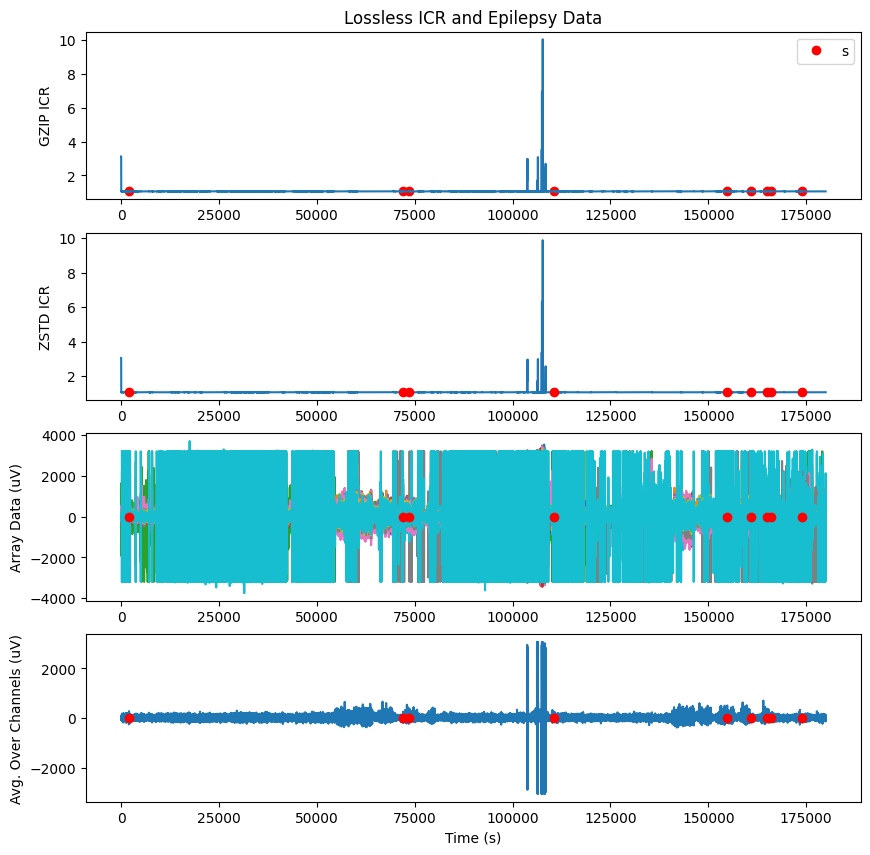

In [37]:
## FIGURES

fig, ax = plt.subplots(nrows=4, ncols=1,figsize = (10,10))

z = ax[0].plot(seize_times,np.ones(len(seize_times))*1.1,'ro',label='seizure times');
ax[0].legend(z,'seizure times');
ax[0].plot(gzip_icr);
ax[0].set_ylabel('GZIP ICR');
ax[0].set_title('Lossless ICR and Epilepsy Data');

ax[1].plot(zstd_icr);
ax[1].set_ylabel('ZSTD ICR')
ax[1].plot(seize_times,np.ones(len(seize_times))*1.1,'ro')

ax[2].plot(data1Hz.T);
ax[2].plot(seize_times,np.ones(len(seize_times)),'ro')
ax[2].set_ylabel('Array Data (uV)')

ax[3].plot(np.mean(data1Hz.T,axis=1));
ax[3].plot(seize_times,np.ones(len(seize_times)),'ro')
ax[3].set_ylabel('Avg. Over Channels (uV)')
ax[3].set_xlabel('Time (s)');

In [38]:
print(seize_times)

[  1907.9749  71987.9749  73667.9749 110687.9749 154727.9749 161027.9749
 164987.9749 165947.9749 173927.9749]


LeveneResult(statistic=61.887813867374064, pvalue=4.359092036419738e-15)


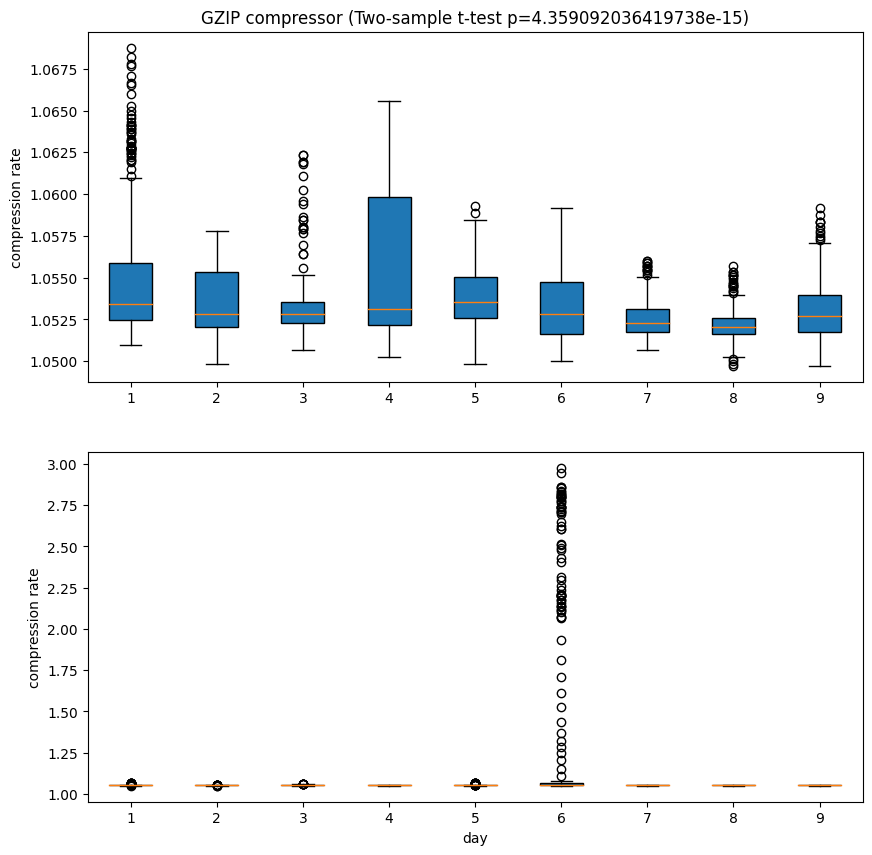

In [98]:
## STATISTICAL TESTING
# ICR values within 5 minutes before/after seizure onset:

# GZIP:
fig, ax1 = plt.subplots(nrows=2, ncols=1,figsize = (10,10))
boxplotdata = np.ones((301,len(seize_times)))
for i in range(len(seize_times)):
    start = math.floor(seize_times[i]-150)
    stop = math.ceil(seize_times[i]+150)
    icr_subset = gzip_icr[start:stop]
    boxplotdata[:,i] = icr_subset
ax1[0].boxplot(boxplotdata,patch_artist=True);

rand_times  = [(random.randrange(150,len(gzip_icr)-150)) for i in range(len(seize_times))]
rand_boxplotdata = np.ones((300,len(seize_times)))
for i in range(len(rand_times)):
    start = math.floor(rand_times[i]-150)
    stop = math.ceil(rand_times[i]+150)
    icr_subset = gzip_icr[start:stop]
    rand_boxplotdata[:,i] = icr_subset
ax1[1].boxplot(rand_boxplotdata,patch_artist=True);

seize_icr = boxplotdata.flatten()
rand_icr = rand_boxplotdata.flatten()

print(stats.levene(seize_icr, rand_icr))
pval = stats.levene(seize_icr, rand_icr)[1]
ax1[0].set_title('GZIP compressor (Two-sample t-test p={})'.format(pval));
ax1[1].set_xlabel("day");
ax1[0].set_ylabel("compression rate");
ax1[1].set_ylabel("compression rate");

LeveneResult(statistic=63.38034424051959, pvalue=2.060850145864051e-15)


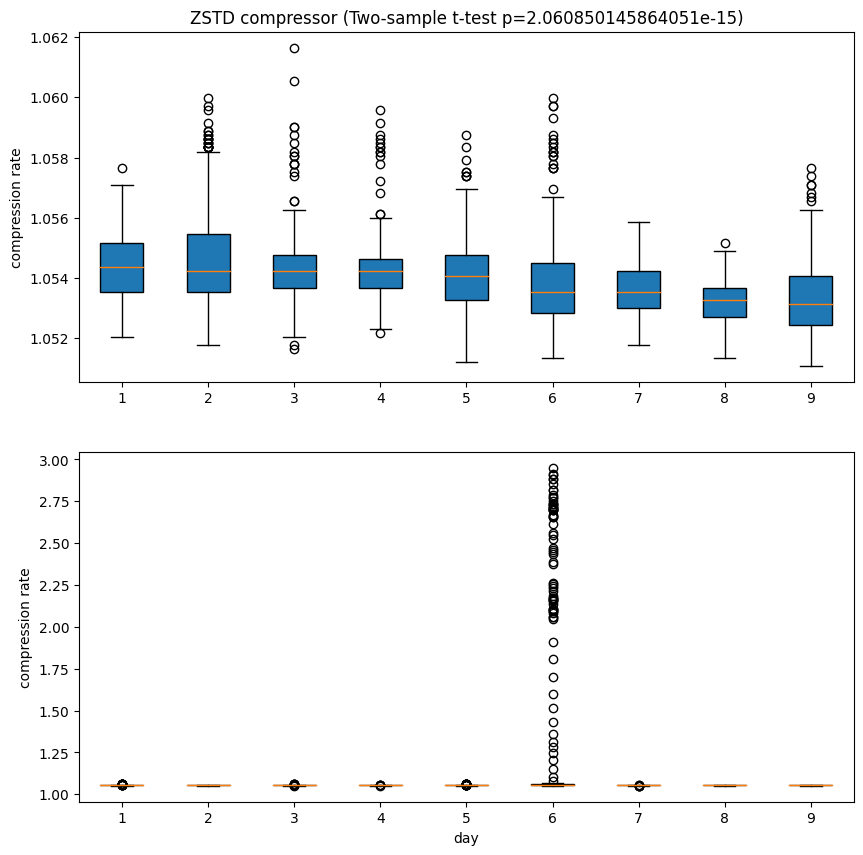

In [99]:
# ZSTD:
fig, ax1 = plt.subplots(nrows=2, ncols=1,figsize = (10,10))
boxplotdata = np.ones((301,len(seize_times)))
for i in range(len(seize_times)):
    start = math.floor(seize_times[i]-150)
    stop = math.ceil(seize_times[i]+150)
    icr_subset = zstd_icr[start:stop]
    boxplotdata[:,i] = icr_subset
ax1[0].boxplot(boxplotdata,patch_artist=True);

rand_boxplotdata = np.ones((300,len(seize_times)))
for i in range(len(rand_times)):
    start = math.floor(rand_times[i]-150)
    stop = math.ceil(rand_times[i]+150)
    icr_subset = zstd_icr[start:stop]
    rand_boxplotdata[:,i] = icr_subset
ax1[1].boxplot(rand_boxplotdata,patch_artist=True);

seize_icr = boxplotdata.flatten()
rand_icr = rand_boxplotdata.flatten()

print(stats.levene(seize_icr, rand_icr))
pval = stats.levene(seize_icr, rand_icr)[1]
ax1[0].set_title('ZSTD compressor (Two-sample t-test p={})'.format(pval));
ax1[1].set_xlabel("day");
ax1[0].set_ylabel("compression rate");
ax1[1].set_ylabel("compression rate");

In [100]:
print(rand_times)

[74026, 150364, 50335, 149460, 7036, 103940, 67481, 137895, 119291]


In [ ]:
## Alice's code graveyard of shame

In [ ]:

# clip signal for visualization
#zstd_icr = np.clip(zstd_icr,0,1.1)
#gzip_icr = np.clip(gzip_icr,0,1.1)

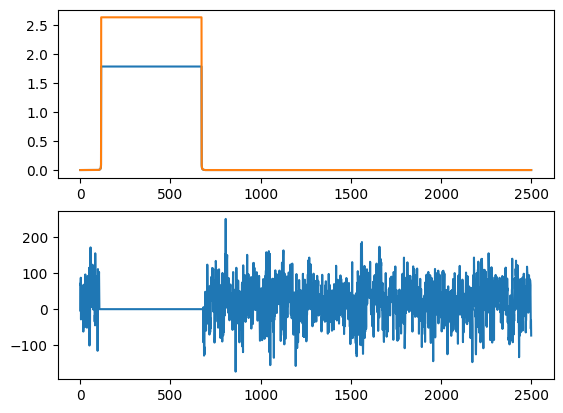

In [40]:
## SUBSET DURING NOISE
start = 92500
stop = 95000
fig, ax = plt.subplots(nrows=2, ncols=1)
ax[0].plot(gzip_icr[start:stop]);
ax[0].plot(zstd_icr[start:stop]);
ax[1].plot(np.mean(data1Hz.T,axis=1)[start:stop]);

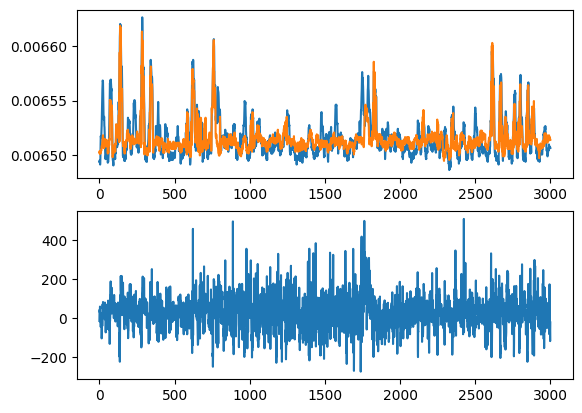

In [73]:
## SUBSET NEAR A SEIZURE
start = 153000
stop = 156000
fig, ax = plt.subplots(nrows=2, ncols=1)
ax[0].plot(gzip_icr[start:stop]);
ax[0].plot(zstd_icr[start:stop]);
ax[1].plot(np.mean(data1Hz.T,axis=1)[start:stop]);

In [48]:
## ACCESS DATA

#np.where(np.array(gzip_icr) > 1.5)

In [49]:
seize_times

array([  1907.9749,  71987.9749,  73667.9749, 110687.9749, 154727.9749,
       161027.9749, 164987.9749, 165947.9749, 173927.9749])

In [ ]:
#gzip_seizure = (np.array(gzip_icr) > 1.5)

In [10]:
gaps

array([[ 3600. ,  3600.1],
       [92605.7, 93181.3],
       [96781.3, 96781.4]])

In [81]:
## THRESHOLDED
gzip_seizure = (np.array(gzip_icr) > 1.5)
zstd_seizure = (np.array(zstd_icr) > 1.5)
real_seizure = (np.mean(data1Hz.T,axis=1)>1000)

In [85]:
gzip_seizure[0:5]

array([ True,  True,  True,  True,  True])

In [96]:
gzip_euclidean_distance = np.sqrt(np.sum((real_seizure != gzip_seizure)**2))
zstd_euclidean_distance = np.sqrt(np.sum((real_seizure != zstd_seizure)**2))

In [97]:
gzip_euclidean_distance

28.26658805020514

In [98]:
zstd_euclidean_distance

28.19574435974337

In [92]:
max_euclidean_distance = np.sqrt(len(real_seizure))
print(max_euclidean_distance)

424.9470555257443
